# Alireza FarajTabrizi 97102185 HW2 Q3

### Importing Libraries and some special Functions

In [2]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


### setting the device to GPU if its possible

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Part 1

### Importing Datasets and Splitting them

In [4]:
train = np.array(pd.read_csv('Q3_train.csv'))
test  = np.array(pd.read_csv('Q3_test.csv'))
np.random.shuffle(train)

x_train = train[:,1:][:int(0.8*train.shape[0])]
y_train = train[:,0][:int(0.8*train.shape[0])]
x_train = torch.from_numpy(x_train)
x_train = x_train.type(torch.float32).to(device)
y_train = torch.from_numpy(y_train).to(device)

x_val = train[:,1:][int(0.8*train.shape[0]):]
y_val = train[:,0][int(0.8*train.shape[0]):]
x_val = torch.from_numpy(x_val)
x_val = x_val.type(torch.float32).to(device)
y_val = torch.from_numpy(y_val).to(device)

x_test = test[:,1:]
y_test = test[:,0]
x_test = torch.from_numpy(x_test)
x_test = x_test.type(torch.float32).to(device)
y_test = torch.from_numpy(y_test).to(device)

### Label Dictionary and Samples Plot

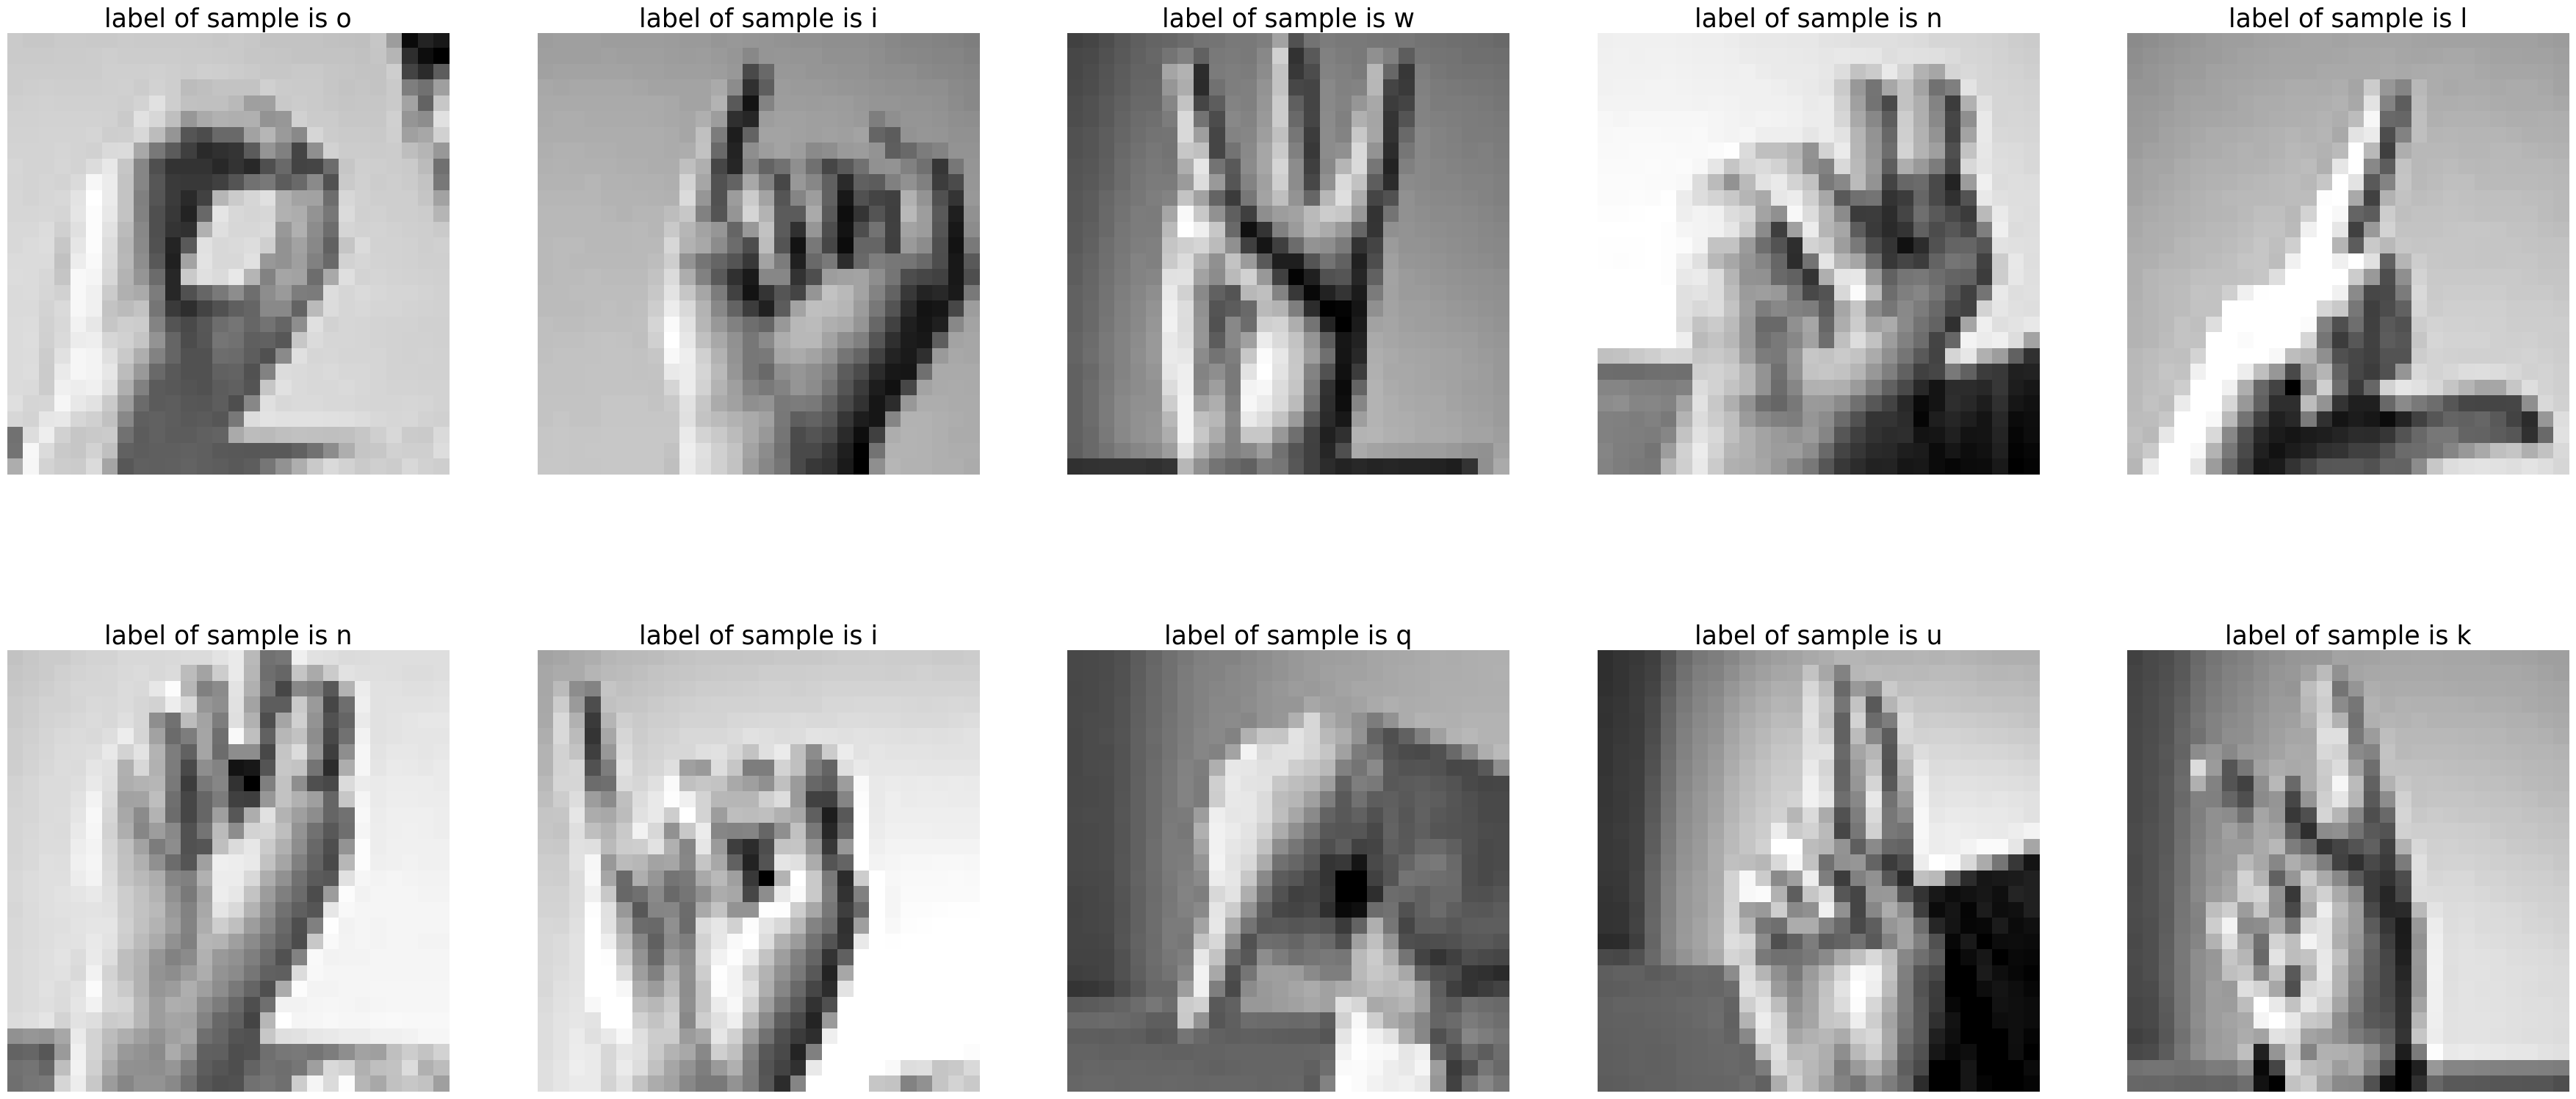

In [5]:
label_dic = dict(zip(np.arange(25),string.ascii_lowercase))

plt.figure(figsize=(45,20))
for i in range(10):
    n = np.random.randint(0,x_train.shape[0])
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[n].cpu().reshape(28,28),cmap='gray')
    plt.axis('off')
    plt.title('label of sample is ' + label_dic[y_train[n].item()], fontsize=25)

## Part 2

### Making a Neural Network

In [6]:
# Defining the Neural Network Layers, Neurons and Activation Function
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 25),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

### Custom Dataset definition

In [7]:
# Defining a Dataset class so I can use my own dataset as an input of the Dataloader function
class Alpha_Hand_Dataset(Dataset):

    def __init__(self, data):
        self.data = data
  
    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, idx):
        sample = self.data[0][idx].to(device),self.data[1][idx].to(device)
        return sample

### Train Loop and Accuracy-Loss function

In [8]:
# Defining the function that will do calculation of Loss and gradiant updates for all Batches in Train Dataset in 1 epoch
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Defining the function that will do calculation of Loss and Accuracy over Test Dataset
def Accuracy_Loss(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    #print(f"Accuracy : {(100*correct):>0.1f}%, Avg loss : {test_loss:>8f} \n")
    return 100*correct, test_loss

In [9]:
# Building the Datasets
training_data = Alpha_Hand_Dataset((x_train,y_train))
val_data = Alpha_Hand_Dataset((x_val,y_val))
test_data = Alpha_Hand_Dataset((x_test,y_test))

# Building the Dataloaders
batch_size = 100
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


### SGD

In [10]:
# setting hyper-parameters
learning_rate = 1e-3
batch_size = 50
epochs = 30
loss_fn = nn.CrossEntropyLoss()

# model and optimizer defenintion
model1_sgd = NeuralNetwork().to(device)
model1_sgd.train()
optimizer = torch.optim.SGD(model1_sgd.parameters(), lr=learning_rate)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

# some list for saving the accuracy and loss over epochs
train_loss_sgd = []
val_loss_sgd = []
test_loss_sgd = []
train_acu_sgd = []
val_acu_sgd = []
test_acu_sgd = []

best_acu = 0
for e in range(epochs):
    train_loop(train_dataloader, model1_sgd, loss_fn, optimizer)
    
    a = Accuracy_Loss(train_dataloader, model1_sgd, loss_fn)
    train_loss_sgd.append(a[1]),train_acu_sgd.append(a[0])
    
    b = Accuracy_Loss(val_dataloader, model1_sgd, loss_fn)
    val_loss_sgd.append(b[1]),val_acu_sgd.append(b[0])
   
    c = Accuracy_Loss(test_dataloader, model1_sgd, loss_fn)
    test_loss_sgd.append(c[1]),test_acu_sgd.append(c[0])
    
    if val_acu_sgd[e]>best_acu:
        best_acu = val_acu_sgd[e]
        torch.save(model1_sgd, 'model1_sgd.pth')
        
model1_sgd = torch.load('model1_sgd.pth')  
print("Best Model Accuracy :",Accuracy_Loss(test_dataloader, model1_sgd, loss_fn)[0])  

Best Model Accuracy : 78.27663134411601


### Adam

In [18]:
learning_rate = 1e-4
batch_size = 50
epochs = 30
loss_fn = nn.CrossEntropyLoss()

# model and optimizer defenintion
model2_adam = NeuralNetwork().to(device)
model2_adam.train()
optimizer = torch.optim.Adam(model2_adam.parameters(), lr=learning_rate)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

# some list for saving the accuracy and loss over epochs
train_loss_adam = []
val_loss_adam = []
test_loss_adam = []
train_acu_adam = []
val_acu_adam = []
test_acu_adam = []

best_acu = 0
for e in range(epochs):
    train_loop(train_dataloader, model2_adam, loss_fn, optimizer)
    
    a = Accuracy_Loss(train_dataloader, model2_adam, loss_fn)
    train_loss_adam.append(a[1]),train_acu_adam.append(a[0])
    
    b = Accuracy_Loss(val_dataloader, model2_adam, loss_fn)
    val_loss_adam.append(b[1]),val_acu_adam.append(b[0])
    
    c = Accuracy_Loss(test_dataloader, model2_adam, loss_fn)
    test_loss_adam.append(c[1]),test_acu_adam.append(c[0])
    if val_acu_adam[e]>best_acu:
        best_acu = val_acu_adam[e]
        torch.save(model2_adam, 'model2_adam.pth')
        
model2_adam = torch.load('model2_adam.pth')  
print("Best Model Accuracy :",Accuracy_Loss(test_dataloader, model2_adam, loss_fn)[0])  


Best Model Accuracy : 82.52928053541551


الگوریتم آدام سریع تر همگرا می شود ( با تعداد ایپاک های کمتر) اما هر ایپاک آن بیشتر طول می کشد. نقطه مثبت آدام حفظ کردن ضریبی ار مقادیر قبلی متغیر و مشتق آن است که حساسیت آن را نسبت به نویز کم می کند

### Loss & Accuracy Plots

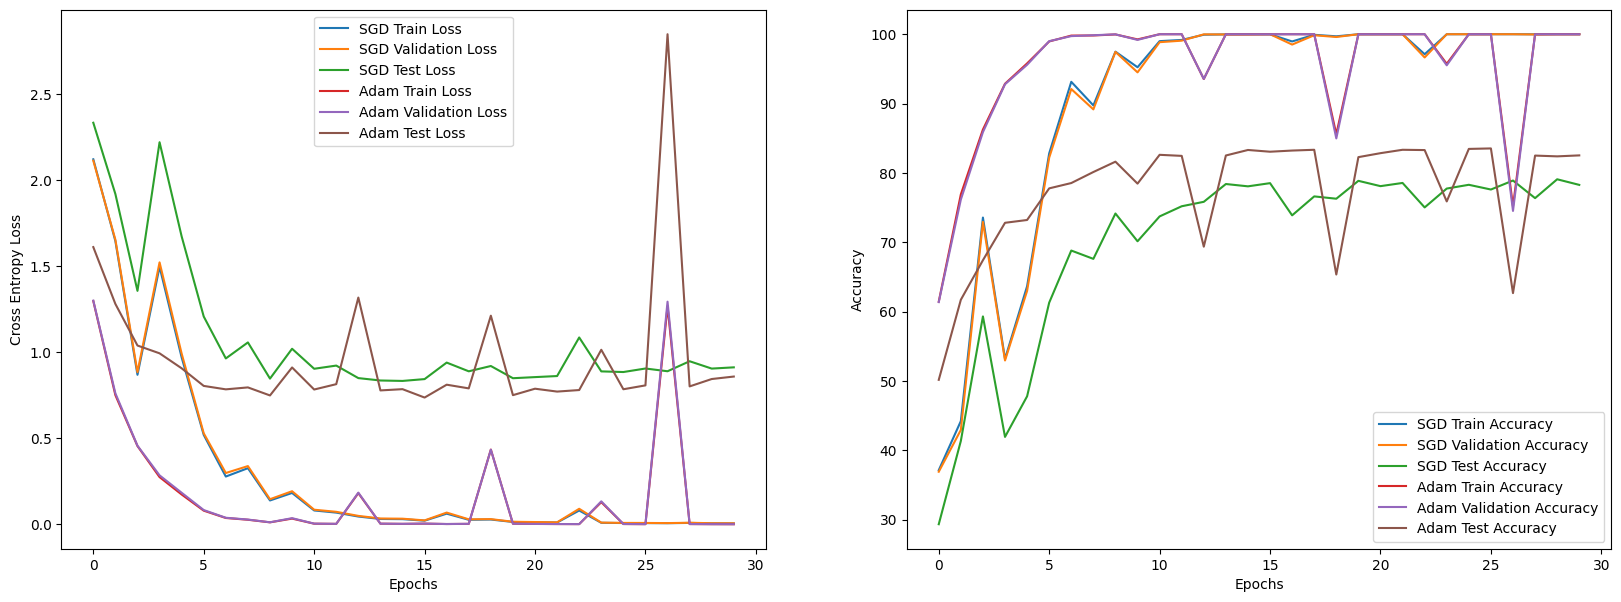

In [21]:
# Plotting the Accuracy over Epochs for both SGD and Adam
plt.figure(figsize=(20,7))
plt.subplot(1, 2, 1)
plt.plot(np.arange(epochs), train_loss_sgd)
plt.plot(np.arange(epochs), val_loss_sgd)
plt.plot(np.arange(epochs), test_loss_sgd)
plt.plot(np.arange(epochs), train_loss_adam)
plt.plot(np.arange(epochs), val_loss_adam)
plt.plot(np.arange(epochs), test_loss_adam)
plt.legend(['SGD Train Loss', 'SGD Validation Loss', 'SGD Test Loss', 'Adam Train Loss', 'Adam Validation Loss', 'Adam Test Loss'])
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')


# Plotting the Accuracy over Epochs for both SGD and Adam
plt.subplot(1, 2, 2)
plt.plot(np.arange(epochs), train_acu_sgd)
plt.plot(np.arange(epochs), val_acu_sgd)
plt.plot(np.arange(epochs), test_acu_sgd)
plt.plot(np.arange(epochs), train_acu_adam)
plt.plot(np.arange(epochs), val_acu_adam)
plt.plot(np.arange(epochs), test_acu_adam)
plt.legend(['SGD Train Accuracy', 'SGD Validation Accuracy', 'SGD Test Accuracy', 'Adam Train Accuracy', 'Adam Validation Accuracy', 'Adam Test Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


 در نمودار بالا قابل مشاهده است که الگوریتم آدام حدود5 ایپاک سریع تر همگرا می شود اما چون هردو در نهایت به دقت حدودا 100 درصدی می رسند در مقدار بهینه ی دقت تفاوتی وجود ندارد اما لاس در آدام نیز کمتر است.
 نکته دیگری که باید به آن توجه کرد تفاوت معنا دار ولدیشن ارور و تست ارور است، دلیل آن بالانس نبودن دیتاست تست است. اگر دیتای ترین و تست را ترکیب کرده و شافل کنید و مجددا اندازه قبلی جدا کنید روی همه ی داده ها به دقت بالای 95 درصد می رسیم

## Part 3

### New Model Defenition

In [14]:
# Defining the Neural Network Layers, Neurons and Activation Function
class NeuralNetwork_dropout(nn.Module):
    def __init__(self):
        super(NeuralNetwork_dropout, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 512),
            nn.Dropout(p=0.05),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.Dropout(p=0.05),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(p=0.05),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Dropout(p=0.05),
            nn.ReLU(),
            nn.Linear(64, 25),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

برای مدل با دراپ اوت بهترین کار این است که احتمال را از 0.1 کمتر بگذرایم وگرنه خیلی کند همگرا می شود

### Dropout

Best Model Accuracy : 80.81427774679308


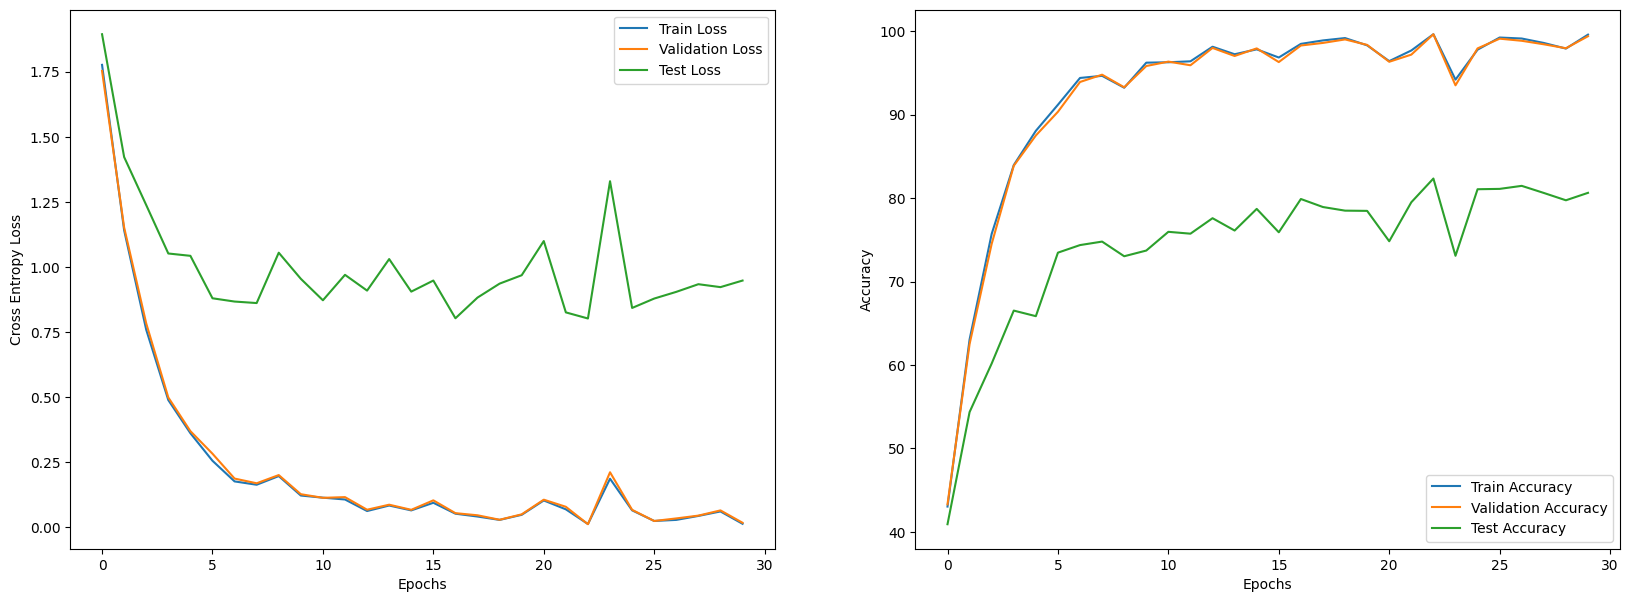

In [15]:
# setting hyper-parameters
learning_rate = 1e-4
batch_size = 50
epochs = 30
loss_fn = nn.CrossEntropyLoss()


# model and optimizer defenintion
model3_adam_drop = NeuralNetwork_dropout().to(device)
model3_adam_drop.train()
optimizer = torch.optim.Adam(model3_adam_drop.parameters(), lr=learning_rate)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

train_loss_drp = []
val_loss_drp = []
test_loss_drp = []
train_acu_drp = []
val_acu_drp = []
test_acu_drp = []

best_acu = 0
for e in range(epochs):
    train_loop(train_dataloader, model3_adam_drop, loss_fn, optimizer)
   
    a = Accuracy_Loss(train_dataloader, model3_adam_drop, loss_fn)
    train_loss_drp.append(a[1]),train_acu_drp.append(a[0])
    
    a = Accuracy_Loss(val_dataloader, model3_adam_drop, loss_fn)
    val_loss_drp.append(a[1]),val_acu_drp.append(a[0])
   
    a = Accuracy_Loss(test_dataloader, model3_adam_drop, loss_fn)
    test_loss_drp.append(a[1]),test_acu_drp.append(a[0])

    if val_acu_drp[e]>best_acu:
        best_acu = val_acu_drp[e]
        torch.save(model3_adam_drop, 'model3_adam_drop.pth')
        
model3_adam_drop = torch.load('model3_adam_drop.pth')  
print("Best Model Accuracy :", Accuracy_Loss(test_dataloader, model3_adam_drop, loss_fn)[0])    
   
# Plotting the Loss over Epochs  
plt.figure(figsize=(20,7))
plt.subplot(1, 2, 1)
plt.plot(np.arange(epochs), train_loss_drp)
plt.plot(np.arange(epochs), val_loss_drp)
plt.plot(np.arange(epochs), test_loss_drp)
plt.legend(['Train Loss', 'Validation Loss', 'Test Loss'])
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')

# Plotting the Accuracy over Epochs 
plt.subplot(1, 2, 2)
plt.plot(np.arange(epochs), train_acu_drp)
plt.plot(np.arange(epochs), val_acu_drp)
plt.plot(np.arange(epochs), test_acu_drp)
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Test Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

## Part 4

### Best model

In [24]:

best_model = model1_sgd

if Accuracy_Loss(test_dataloader, model3_adam_drop, loss_fn)[0] < Accuracy_Loss(test_dataloader, model2_adam, loss_fn)[0]:
    best_model = model2_adam
    
if Accuracy_Loss(test_dataloader, best_model, loss_fn)[0] < Accuracy_Loss(test_dataloader, model3_adam_drop, loss_fn)[0]:
    best_model = model3_adam_drop

print(best_model)
print("Best Model Accuracy :", Accuracy_Loss(test_dataloader, best_model, loss_fn)[0])

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=25, bias=True)
  )
)
Best Model Accuracy : 82.52928053541551


معمولا بهترین مدل، مدلی است که با دراپ اوت است و دقتی حدود 80 درصد دارد. 

## Part 5

### My Own Samples

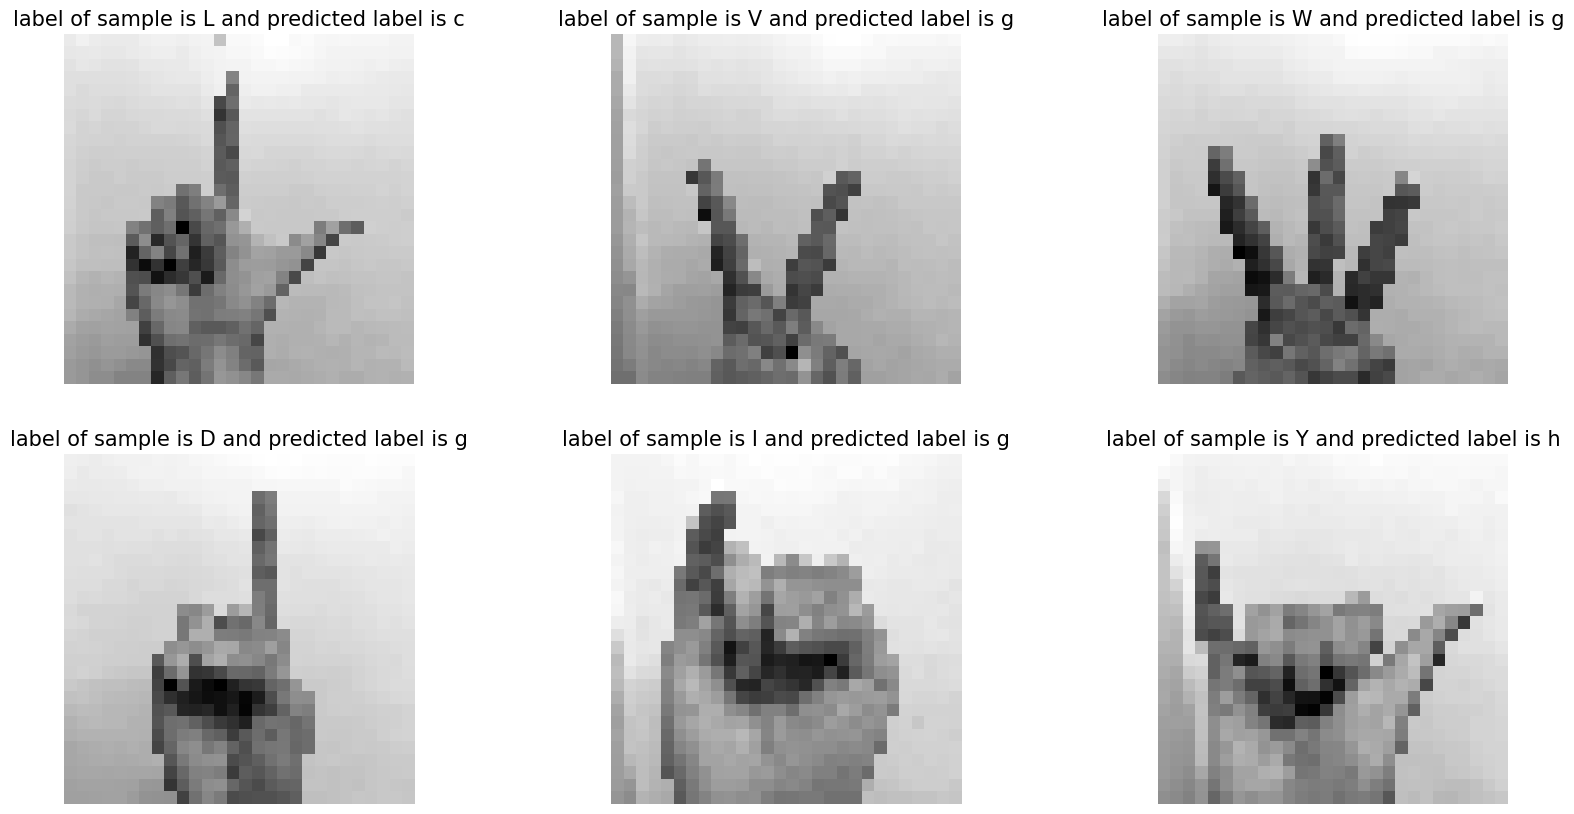

In [26]:
from skimage import io
import cv2
L_img = io.imread('L.jpg')
V_img = io.imread('V.jpg')
W_img = io.imread('W.jpg')
D_img = io.imread('D.jpg')
I_img = io.imread('I.jpg')
Y_img = io.imread('Y.jpg')

L_img = cv2.cvtColor(L_img, cv2.COLOR_BGR2GRAY)
V_img = cv2.cvtColor(V_img, cv2.COLOR_BGR2GRAY)
W_img = cv2.cvtColor(W_img, cv2.COLOR_BGR2GRAY)
D_img = cv2.cvtColor(D_img, cv2.COLOR_BGR2GRAY)
I_img = cv2.cvtColor(I_img, cv2.COLOR_BGR2GRAY)
Y_img = cv2.cvtColor(Y_img, cv2.COLOR_BGR2GRAY)

L_img = cv2.resize(L_img,(28,28))
V_img = cv2.resize(V_img,(28,28))
W_img = cv2.resize(W_img,(28,28))
D_img = cv2.resize(D_img,(28,28))
I_img = cv2.resize(I_img,(28,28))
Y_img = cv2.resize(Y_img,(28,28))

L_img2 = L_img.reshape(784)
V_img2 = V_img.reshape(784)
W_img2 = W_img.reshape(784)
D_img2 = D_img.reshape(784)
I_img2 = I_img.reshape(784)
Y_img2 = Y_img.reshape(784)

L_img2 = torch.from_numpy(L_img2)
V_img2 = torch.from_numpy(V_img2)
W_img2 = torch.from_numpy(W_img2)
D_img2 = torch.from_numpy(D_img2)
I_img2 = torch.from_numpy(I_img2)
Y_img2 = torch.from_numpy(Y_img2)

L_img2 = L_img2.type(torch.float32).to(device)
V_img2 = V_img2.type(torch.float32).to(device)
W_img2 = W_img2.type(torch.float32).to(device)
D_img2 = D_img2.type(torch.float32).to(device)
I_img2 = I_img2.type(torch.float32).to(device)
Y_img2 = Y_img2.type(torch.float32).to(device)

plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.imshow(L_img,cmap='gray')
plt.axis('off')
plt.title('label of sample is L and predicted label is ' + label_dic[best_model(L_img2).argmax().item()], fontsize=15)
plt.subplot(2,3,2)
plt.imshow(V_img,cmap='gray')
plt.axis('off')
plt.title('label of sample is V and predicted label is ' + label_dic[best_model(V_img2).argmax().item()], fontsize=15)
plt.subplot(2,3,3)
plt.imshow(W_img,cmap='gray')
plt.axis('off')
plt.title('label of sample is W and predicted label is ' + label_dic[best_model(W_img2).argmax().item()], fontsize=15)
plt.subplot(2,3,4)
plt.imshow(D_img,cmap='gray')
plt.axis('off')
plt.title('label of sample is D and predicted label is ' + label_dic[best_model(D_img2).argmax().item()], fontsize=15)
plt.subplot(2,3,5)
plt.imshow(I_img,cmap='gray')
plt.axis('off')
plt.title('label of sample is I and predicted label is ' + label_dic[best_model(I_img2).argmax().item()], fontsize=15)
plt.subplot(2,3,6)
plt.imshow(Y_img,cmap='gray')
plt.axis('off')
plt.title('label of sample is Y and predicted label is ' + label_dic[best_model(Y_img2).argmax().item()], fontsize=15)
plt.show()




با این در این قسمت سعی کردم حروفی که با دیگر حروف تفاوت واضحی دارند را انتخاب کنم اما نتیجه مطلوب نبود. احتمالا میزان نور و سایه های عکس هایم با دیتاست خیلی متفاوت است.